[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers(상태 리듀서)

## 복습

`TypedDict`, `Pydantic`, `Dataclasses` 등 LangGraph 상태 스키마를 정의하는 여러 방법을 살펴보았습니다.

## 목표

이제 상태 스키마 내 특정 키/채널에 대한 상태 업데이트 방식을 지정하는 리듀서에 대해 자세히 알아보겠습니다.

In [14]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## 상태의 기본 동작: 덮어쓰기

상태 스키마로 `TypedDict`를 사용해 보겠습니다.

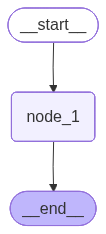

In [15]:
from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    foo: int


def node_1(state):
    print("---Node 1---")
    return {"foo": state["foo"] + 1}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
graph.invoke({"foo": 1})

---Node 1---


{'foo': 2}

상태 업데이트 부분인 `return {"foo": state['foo'] + 1}`을 살펴보겠습니다.

앞서 설명했듯이, LangGraph는 기본적으로 상태를 업데이트하는 방법을 알지 못합니다.
 
따라서 `node_1`에서 `foo` 값을 단순히 덮어쓰게 됩니다:

```
return {"foo": state['foo'] + 1}
```
 
입력 값으로 `{'foo': 1}`을 전달하면, 그래프에서 반환되는 상태는 `{'foo': 2}`가 됩니다.

## 분기

노드가 분기되는 경우를 살펴보겠습니다.

In [17]:
class State(TypedDict):
    foo: int


def node_1(state):
    print("---Node 1---")
    return {"foo": state["foo"] + 1}


def node_2(state):
    print("---Node 2---")
    return {"foo": state["foo"] + 1}


def node_3(state):
    print("---Node 3---")
    return {"foo": state["foo"] + 1}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
# display(Image(graph.get_graph().draw_mermaid_png()))

![](https://i.imgur.com/dIFYerC.png)

In [18]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"foo": 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


문제가 발생했습니다!

`node_1`은 `node_2`와 `node_3`으로 분기합니다.

`node_2`와 `node_3`은 병렬로 실행되며, 이는 그래프의 동일한 단계에서 실행됨을 의미합니다.

두 노드 모두 *동일한 단계 내에서* 상태를 덮어쓰려고 시도합니다.

이는 그래프에 대해 모호합니다! 어떤 상태를 유지해야 할까요?

## 리듀서(Reducers)

[reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers)는 이 문제를 해결하는 일반적인 방법을 제공합니다.

리듀서는 업데이트 수행 방식을 지정합니다.

`Annotated` 타입을 사용해 리듀서 함수를 지정할 수 있습니다.

예를 들어, 각 노드에서 반환된 값을 덮어쓰기 대신 연결해 추가해 보겠습니다.

이를 수행할 수 있는 리듀서가 필요합니다: `operator.add`는 Python 내장 operator 모듈의 함수입니다.

`operator.add`가 리스트에 적용되면 리스트 연결을 수행합니다.

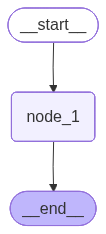

In [19]:
from operator import add
from typing import Annotated


class State(TypedDict):
    foo: Annotated[list[int], add]


def node_1(state):
    print("---Node 1---")
    return {"foo": [state["foo"][0] + 1]}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
graph.invoke({"foo": [1]})

---Node 1---


{'foo': [1, 2]}

이제 상태 키 `foo`는 리스트입니다.

이 `operator.add` 리듀서 함수는 각 노드에서 오는 업데이트를 이 리스트에 추가합니다.

In [21]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state["foo"][-1] + 1]}


def node_2(state):
    print("---Node 2---")
    return {"foo": [state["foo"][-1] + 1]}


def node_3(state):
    print("---Node 3---")
    return {"foo": [state["foo"][-1] + 1]}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
# display(Image(graph.get_graph().draw_mermaid_png()))

![](https://i.imgur.com/dIFYerC.png)

노드 2와 3의 업데이트는 동일한 단계에 속하기 때문에 동시에 수행됨을 확인할 수 있습니다.

In [22]:
graph.invoke({"foo": [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

이제 `foo`에 `None`을 전달하면 어떻게 되는지 살펴보겠습니다.

리듀서인 `operator.add`가 `node_1`에서 입력으로 전달된 `NoneType`을 리스트에 연결하려고 시도하기 때문에 오류가 발생합니다.

In [23]:
try:
    graph.invoke({"foo": None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## 사용자 정의 리듀서

이와 같은 경우를 처리하기 위해 [사용자 정의 리듀서를 정의할 수도 있습니다](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state).

예를 들어, 목록을 결합하고 입력값 중 하나 또는 둘 다 `None`일 수 있는 경우를 처리하는 사용자 정의 리듀서 로직을 정의해 보겠습니다.

In [ ]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
            If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class DefaultState(TypedDict):
    foo: Annotated[list[int], add]


class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

`node_1`에서 값 2를 추가합니다.

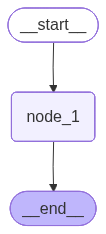

TypeError occurred: can only concatenate list (not "NoneType") to list


In [25]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}


# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

이제 사용자 정의 리듀서로 시도해 보세요. 오류가 발생하지 않는 것을 확인할 수 있습니다.

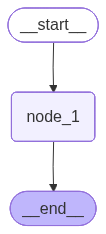

---Node 1---
{'foo': [2]}


In [26]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

모듈 1에서 상태의 메시지를 처리하기 위해 내장 리듀서인 `add_messages`를 사용하는 방법을 살펴봤습니다.

또한 [메시지를 다룰 때 `MessagesState`가 유용한 단축 방법이라는 것도 보여드렸습니다](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate). 

* `MessagesState`에는 내장된 `messages` 키를 가지고 있습니다
* 이 키에 대한 내장 `add_messages` 리듀서도 포함되어 있습니다.

이 두가지 방법은 동일합니다.

간결함을 위해 `from langgraph.graph import MessagesState`를 통해 `MessagesState` 클래스를 사용하겠습니다.


In [27]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# add_messages 리듀서를 사용하여 메시지 목록을 포함하는 사용자 정의 TypedDict 정의
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc


# add_messages 리듀서를 포함하는 메시지 키를 가진 MessagesState를 사용하십시오.
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    added_key_1: str
    added_key_2: str
    # etc

`add_messages` 리듀서의 사용법에 대해 좀 더 이야기해 보겠습니다.

In [ ]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [
    AIMessage(content="안녕하세요! 무엇을 도와드릴까요?", name="Model"),
    HumanMessage(content="해양 생물학에 관한 정보를 찾고 있습니다.", name="Lance"),
]

# New message to add
new_message = AIMessage(
    content="물론 도와드릴 수 있어요. 구체적으로 어떤 부분에 관심이 있으신가요?",
    name="Model",
)

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, name='Model', id='a10e3e0b-09d2-4138-b418-9d1f10eb1201'),
 HumanMessage(content='해양 생물학에 관한 정보를 찾고 있습니다.', additional_kwargs={}, response_metadata={}, name='Lance', id='eba0e512-bbfe-49cf-b8bf-8333d75450a3'),
 AIMessage(content='물론 도와드릴 수 있어요. 구체적으로 어떤 부분에 관심이 있으신가요?', additional_kwargs={}, response_metadata={}, name='Model', id='c65d623c-18e5-4f5d-a75e-aaabba669b40')]

따라서 `add_messages`를 사용하면 상태의 `messages` 키에 메시지를 추가할 수 있음을 알 수 있습니다.

### 메시지 재작성

`add_messages` 리듀서를 사용할 때 유용한 몇 가지 방법을 살펴보겠습니다.

`messages` 목록에 이미 존재하는 메시지와 동일한 ID를 가진 메시지를 전달하면, 기존 메시지가 덮어쓰게 됩니다!

In [29]:
# Initial state
initial_messages = [
    AIMessage(content="안녕하세요! 무엇을 도와드릴까요?", name="Model", id="1"),
    HumanMessage(
        content="해양 생물학에 관한 정보를 찾고 있습니다.", name="Lance", id="2"
    ),
]

# New message to add
new_message = HumanMessage(
    content="고래에 관한 정보를 찾고 있습니다, 특히", name="Lance", id="2"
)

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='안녕하세요! 무엇을 도와드릴까요?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content='고래에 관한 정보를 찾고 있습니다, 특히', additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### 메시지 제거

`add_messages`는 또한 [메시지 제거 기능을 활성화합니다](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/). 

이를 위해 `langchain_core`의 [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html)를 사용합니다.

In [30]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("안녕하세요.", name="Bot", id="1")]
messages.append(HumanMessage("안녕하세요.", name="Lance", id="2"))
messages.append(
    AIMessage("그러니까 해양 포유류를 연구하고 있다고 하셨나요?", name="Bot", id="3")
)
messages.append(
    HumanMessage(
        "네, 고래에 대해서는 알고 있어요. 그런데 다른 것들은 무엇을 배워야 할까요?",
        name="Lance",
        id="4",
    )
)

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [31]:
add_messages(messages, delete_messages)

[AIMessage(content='그러니까 해양 포유류를 연구하고 있다고 하셨나요?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='네, 고래에 대해서는 알고 있어요. 그런데 다른 것들은 무엇을 배워야 할까요?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

`delete_messages`에 명시된 메시지 ID 1과 2가 리듀서에 의해 제거되는 것을 확인할 수 있습니다.

이것이 실제로 적용되는 모습은 조금 후에 살펴보겠습니다.